In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [ ]:
!pip install tensorboardcolab
# To generate GIFs
!pip install -q imageio

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np 
import time
import datetime, os
import glob
import imageio
import PIL
import time

from IPython import display
from tensorflow.keras import layers
from google.colab import files


In [ ]:
from subprocess import getoutput
s = getoutput('nvidia-smi')
if 'K80' in s:
  gpu = 'K80'
elif 'T4' in s:
  gpu = 'T4'
elif 'P100' in s:
  gpu = 'P100'
  display.HTML(f"<h2>{gpu}</h2>")
print(s)
# or simply
!nvidia-smi -L

Thu Jul 23 11:06:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    58W / 149W |    130MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

The Dataset is located in the Google Drive, for this reason the link with Google Coolab is required. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Tensorboard** is loaded, this is useul at the end of the code when the charts are generated from the data extracted during the all training

In [ ]:
%load_ext tensorboard

The Dataset is located on the Google Drive in .zip extension. In the following code the dataset is extracted  and become possible to use. \\
After the extraction the dataset is loaded in the Google Colab dataset folder. \\

The **models_dir** is the directory where the models will be saved in order to reuse them.

In [ ]:
from zipfile import ZipFile

with ZipFile('path/of/your/dataset.zip', 'r') as zipObj:
 
   # Extract all the contents of zip file in different directory
   zipObj.extractall('/content/dataset/')
   path = '/content/dataset/40k_dataset/'
   
   #folder where the model is saved
   models_dir =  '/path/where/to/save/the/model/'

The **decode_img** function is really useful to elaborate every single image. The main instructions are: 

*   **tf.image.decode_jpeg**: decode a JPEG image to a uint8 tensor, this function takes an image and the number of channels. In this case the number is $3$ because the output choosen is an RGB image.
*   **tf.image.convert_image_dtype**: return an image converted in dtype. The image is the rapresented in floating points in the range $[0,1]$ 




After converting the image, it is normalized again in the range $[-1,1]$, for the benefit of the **tahn** ativation function choosen in the generator. \\

The image is then resized to $[132,132]$. \\

**Data Augmentation** is performed to improve the performance of the model by increasing the diversity in the dataset and to avoid the overfitting of the model. To do so, the following choices have been made: 

*   **tf.image.flip_left_right**: the image is flipped left to right if from the **random.uniform** a number $> 0.5$ is drawn 
*   **tf.image.random_crop**: the image is cropped and resized to $[128,128]$
*   **tf.image.random_saturation**: With a certain probability it changes the saturation of the image in  range of values.
*  **tf.image.random_contrast**: With a certain probability it changes the contrast of the image in  range of values.

The **process_path** function plays a main role. It takes each image from the dataset and calls the **decode_img** function and then return the image.



(132, 132, 3)


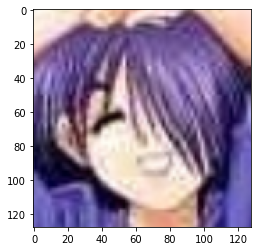

In [ ]:

#@title
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)

  #color jitter
  if tf.random.uniform(()) > 0.7:
    img = tf.image.random_saturation(img, 0.5, 2)
    img = tf.image.random_contrast(img, 0.5, 2)

  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)

  #normalization between -1 and 1
  img = (img -0.5 )/0.5

  img =  tf.image.resize(img, [132, 132])
  print(img.shape)

  #some data augmentation ....
  if tf.random.uniform(()) > 0.5:
    img = tf.image.flip_left_right(img)

  # resize the image to the desired size.
  img = tf.image.random_crop(img, size=[128, 128, 3])
  
  #-------------------------------------------------------------

  
  return img

def process_path(file_path):
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

# here we show an image loaded from the dataset after the above steps
inp = process_path(path+ '0_2000.jpg')
plt.figure()
plt.imshow((inp +1)/2)



With **tf.data.Dataset.list_files** a dataset of all files matching a pattern, then by using **ds.map**  the function **process_path** is applied to each element of the dataset and returns a new dataset containing the transformed elements in the same order as they apperead in the input. The number of parallel calls is setted in **tf.data.experimental.AUTOTUNE** which means that they are set dynamically based on available CPU. \\

The dataset fills a buffer with **buffer_size** elements, then randomly samples elements from this buffer, replacing the selected elements with the new elemtns. The **buffer_size** is set to the same number of element of the dataset to perform a perfect shuffling. \\

Finally with **batch** consecutive elements are combined into batches. The reason to use a **small batch** is that they are noisy and they offer a regularizing effect and lower generalization error. Furthermore they make easier to fit one batch worth of training data in memory, so when using a GPU.
Other important motivations are that with a smaller batch size, the number of iterations of training is usually reduced, furthermore it leads to a higher accuracy overall, so a neural network wich performs better.




(132, 132, 3)


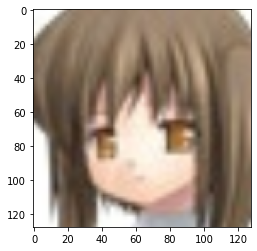

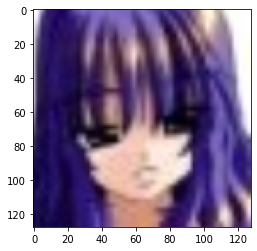

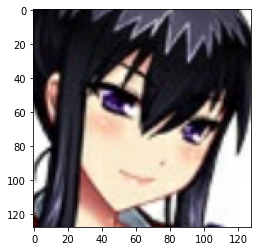

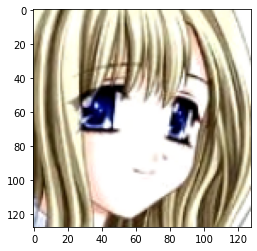

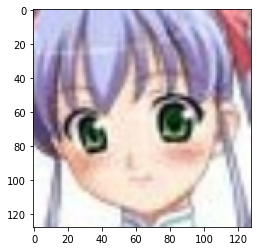

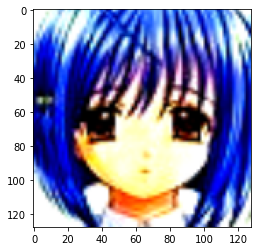

In [ ]:

BUFFER_SIZE = 40000
batch_size = 25
ds= tf.data.Dataset.list_files('/content/dataset/40k_dataset/*.jpg')
ds = ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

for i in ds.take(6):
  plt.figure()
  plt.imshow((i+1)/2)

ds = ds.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True).batch(batch_size) # the reshuffle at each iteration allows to have always different order of the images selection





The two metrics are used when the **Tensorboard chart** is generated. 

In [ ]:

generator_loss = tf.keras.metrics.Mean(name='generator_loss', dtype=tf.float32)
discriminator_loss = tf.keras.metrics.Mean(name='discriminator_loss', dtype=tf.float32)


The motivation behind the choices made for both discriminator and generator are the following ones: 

1.   **tf.initializers.RandomNormal**: By making weights as non zero ( but close to 0 like 0.1 etc), the algorithm will learn the weights in next iterations and won't be stuck. This solution is to avoid to initialized the weights to 0 (each hidden unit will get exactly the same signal) or 1(each unit gets signal equal to sum of inputs). The best practice for DCAGAN models is to initialize all weights using a zero-centered Gaussian distribution with a standard deviation of 0.02.

2. **BatchNormalization**:  Batch norm layers with the a correct set of kernels or filters can help in reaching sharper generated images, otherwise this solution could lead to a discriminator loss which quicly reaches 0. The batch norm layers are recommended in both the discriminator and generator models, except the output of the generator and input to the discriminator. 
It normalize the flowing data in the whole network, furthermore it is a good remedy to vanishing gradient problem. the BN increases memory consumption, but it speeds up network convergence a lot!

3. **padding='same'**:  The padding argument of the layer can be set to ‘same’ to force the output to have the desired (doubled) output shape. This is done for both the discriminator when downsampling and for generator when upsampling.

4. **tf.optimizers.Adam**: A part from the learning rate at $0.0002 $ that seems to work better instead of other choices, the momentum term $β1$ is set to 0.5 which helps to stabilize the traing insted of using the defaul value of $0.9$

5. **strides**: By set the strides to $(2,2)$ it has the effect of downsampling(or upsamplig in the case of the generator) the input, specifically halving the width and height of the input, resulting in output feature maps with one quarter the area. In other words in each layer Conv2D the output will be the half of the previus layer, while for the generator with Conv2DTranspose the output will be doubled with respect to the previus one.

6. **Kernels**: Use $5 \times 5$ kernels cover more pixel in the previus layer than using $3 \times 3$ kernels. This lead to look at more information instead of using $3 \times 3$ kernel in the discriminator causing the discriminator loss to rapidly approach $0$. The reason regariding the generator is that with larger kernels at the top convolution layers is possible to mantain some kind of smoothness. For the other layer it seems there is no difference between use of differnt kernel size.

7. **Filters**: More filters are usually desiderable. If in the generator the filters are low it could end in making images too blurry. With more filter it is possible to capture additional information which can eventually add sharpeness to the generated images. 

8. **Considerations**: A good balance between discriminator and generator is needed, if the discriminator is too strong this will end up in  a situation where the discriminator doesn't provide enought information for the generator to make progess, therefore the generator training can fail due to vanishing gradients. On the other hand a generator which is too strong it easely fool the discriminator producing trash.

9. **Activation Functions**: ReLU is used to address the problem of vanishing gradients and to promote sparse activations, so lots of zero values. **ReLU** is reccomended for the generator but for the discriminator the **Leaky Relu** that allows values less than zero, is preferred.

10.  **Activation Functions in the last layers**: The choice of activation function is most important for the output layer as it will define the format that predictions will take. For the discriminator the **linear** activation function(or None) and the number of neurons matching the number of outpus is used. For the generator the **tahn** activation function is preferred to transform the output to the range $[–1, 1]$, to match the original image domain.






In [ ]:
def make_discriminator_model():

# Initializers define the way to set the initial random weights of Keras layers.
    init = tf.initializers.RandomNormal(stddev=0.02)
  
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(32, (5,5), padding='same', kernel_initializer=init, input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(64, (5,5), padding='same', strides=(2, 2), kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))


    model.add(layers.Conv2D(128, (5,5), padding='same', strides=(2, 2), kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, (5,5), padding='same', strides=(2, 2), kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, (5,5), padding='same', strides=(2, 2), kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(512, (5,5), padding='same', strides=(2, 2), kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='linear',kernel_initializer=init))

    return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

tf.keras.utils.plot_model(discriminator, to_file="discriminator.png")
discriminator_optimizer = tf.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       5

Essentialy two losses are compared to evaluate the results obtained: 


1.   The classic **BinaryCrossentropy** loss function  which has been widely use in GANs even it it toruned out to be not so stable. In general the choice of cross-entropy loss means that points generated far from the boundary are right or wrong, but provide very little gradient information to the generator on how to generate better images. This small gradient for generated images far from the decision boundary is referred to as a vanishing gradient problem or a loss saturation. The loss function is unable to give a strong signal as to how to best update the model.
2. **MeanSquaredError** loss function will penalize generated images based on their distance from the decision boundary. This will provide a strong gradient signal for generated images that are very different or far from the existing data and address the problem of saturated loss. This loss function is becoming more and more popular due the fact which is more stable and leads to good results.

One of the most important improvements regarding the losses is the introduction of the **Smooth Labeling** to reduce the overconfidence by penalizing the Discriminator by associating each target label between $0.7$ and $1.2$, this is done for both the real_loss and fake_loss where the range in this case is between $0.0$ and $0.3$.



In [ ]:
# This method returns a helper function to compute cross entropy loss
#cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError()


In [ ]:

def get_discriminator_loss(real_output, fake_output):

    real_loss = mse(tf.random.uniform(real_output.shape, 0.7, 1.2), real_output) # smooth labeling for reals
    fake_loss = mse(tf.random.uniform(real_output.shape, 0.0, 0.3), fake_output) # smooth labeling for fakes  
    total_loss = real_loss + fake_loss
    return total_loss


In [ ]:

def make_generator_model():

    init = tf.initializers.RandomNormal(stddev=0.02)
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(4*4*1024, kernel_initializer=init, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.Reshape((4, 4, 1024)))
    assert model.output_shape == (None, 4, 4, 1024) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, (3,3), strides=(2, 2), padding='same',kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    assert model.output_shape == (None, 8, 8, 512)

    model.add(layers.Conv2DTranspose(512, (3,3), strides=(2, 2), padding='same', kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    assert model.output_shape == (None, 16, 16, 512)

    model.add(layers.Conv2DTranspose(512, (3,3), strides=(1, 1), padding='same', kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    assert model.output_shape == (None, 16, 16, 512)

    model.add(layers.Conv2DTranspose(256, (3,3), strides=(2, 2), padding='same', kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    assert model.output_shape == (None, 32, 32, 256)

    model.add(layers.Conv2DTranspose(256, (3,3), strides=(2, 2), padding='same', kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    assert model.output_shape == (None, 64, 64, 256)

    model.add(layers.Conv2DTranspose(128, (3,3), strides=(2, 2), padding='same', kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    assert model.output_shape == (None, 128, 128, 128)

    model.add(layers.Conv2DTranspose(128, (3,3), strides=(1, 1), padding='same', kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    assert model.output_shape == (None, 128, 128, 128)

    model.add(layers.Conv2D(3, (5, 5), padding='same', kernel_initializer=init, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)

    return model

In [ ]:
generator = make_generator_model()
generator.summary()

tf.keras.utils.plot_model(generator, to_file="generator.png")
generator_optimizer = tf.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
batch_normalization_5 (Batch (None, 16384)             65536     
_________________________________________________________________
activation (Activation)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 512)         4719104   
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 512)        

In [ ]:
def get_generator_loss(fake_output):
    #return cross_entropy(tf.ones_like(fake_output), fake_output)
    return mse(tf.ones_like(fake_output), fake_output)


Create the models folder in order to save the model after a certain number of epochs. The last model will be uploaded when there is the need of doing it.

In [ ]:
checkpoint_dir = models_dir
if tf.io.gfile.exists(checkpoint_dir ):
  print('Models folder already created')
else:
  tf.io.gfile.makedirs(checkpoint_dir)
  print('Models folder created')

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Models folder already created


In [ ]:
#Load a saved model

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


This code generated a random noise, the image showed is denormalized from $[-1,1]$ to $[0,1]$ to avoid clipping problems. If the generator is trained, this section will return a generated sample.

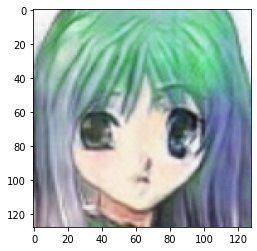

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise,  training=False)
generated_image= tf.squeeze(generated_image)

plt.imshow((generated_image + 1) /2)
plt.show()

In [ ]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 49

# We will reuse this seed overtime (so it's easier
# to visualize progress in plot below)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. 

At the beginning of the training loops the generator recives a random seed as imput which is used to produce an image: 

*   *noise = tf.random.normal([batch_size, noise_dim])*

The discriminator is then used to classify real image(drawn from the training set) and fake images(produced by the generator): 

1.   *real_output = discriminator(images, training=True)*
2.   *fake_output = discriminator(generated_images, training=True)*

With a probability of $0.5$ **the labels are flipped**, this in order to introduce a noise, which avoid the loss to reach 0 faster.

The loss is calculated for each of these model: 

1.   *gen_loss = get_generator_loss(fake_output)*
2.   *disc_loss = get_discriminator_loss(real_output, fake_output)*

The gradients are used to update the generator and discriminator.


1.   *gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)*
2.   *gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)*

3. *generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))*
4. *discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))*

The last due code lines are used to keep track of the losses in order to build the chart on Tensorboard: 

1.   *generator_loss(gen_loss)* 
2.   *discriminator_loss(disc_loss)*




In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim]) #we generate a random gaussian vector of specified dimension

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: #GradientTape records operations for automatic differentiation

      generated_images = generator(noise, training=True) # generates a number of images equivalent to the batch size
      
      if (tf.random.uniform(())>0.95): #introduce a low probability of noisy labels
        real_output = discriminator(generated_images, training=True)
      else:
        real_output = discriminator(images, training=True)

      fake_output = discriminator(generated_images, training=True)

      gen_loss = get_generator_loss(fake_output) 
      disc_loss = get_discriminator_loss(real_output, fake_output)

    # comuptes the gradients for generator and discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) 
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # apply the gradients updating the weights of the 2 models
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # -- TENSORBOARD --
    generator_loss(gen_loss)
    discriminator_loss(disc_loss)

   

The Tensorboar folder to draw the charts are created. 

In [ ]:

logs_base_dir = "/path/of/log_dir"
if tf.io.gfile.exists(logs_base_dir):
  print('Tensorboard folder already created')
else:
  tf.io.gfile.makedirs(logs_base_dir)
  print('Tensorboard folder created')
logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
train_summary_writer = tf.summary.create_file_writer(logdir + '/train')

logs_base_dir = "/path/of/log_dir/" 


Tensorboard folder already created


Here the image folder where to stors the generated images at each epoch is created

In [ ]:
image_dir = "/path/where/to/store/generated_images"
if tf.io.gfile.exists(image_dir):
  print('Images folder already created')
else:
  tf.io.gfile.makedirs(image_dir)
  print('Images folder created')


Images folder already created


The **train_step** function is called on each **image_batch** which has size of $25$. After using each image batch till the end of the dataset, then the epoch is incremented. 
The Training is usually stopped when the generator is able to output good samples. Most of the times this happens between $100$ and $300$ epochs.  
In this function are also printed the information about the training and the images are drawn and saved, with the **generate_and_save_images** function

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
     
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 10 epochs
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    with train_summary_writer.as_default():
      tf.summary.scalar('generator_loss', generator_loss.result(), step=epoch)
      tf.summary.scalar('discriminator_loss', discriminator_loss.result(), step=epoch)

    template = 'Time for epoch {} is {} sec,\n Generator Loss : {}, \n Discriminator Loss: {}'
    print (template.format(epoch + 1, time.time()-start, generator_loss.result(),
           discriminator_loss.result()))



  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  

  # this is for tensorboard - reset metrics every epoch
  generator_loss.reset_states()
  discriminator_loss.reset_states()

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(predictions.shape[0]):
      plt.subplot(7, 7, i+1)
      plt.imshow((predictions[i,...]+1)/2)
      plt.axis('off')

  plt.savefig('/path/to/images_definitive/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('/path/to/images_definitive/image_at_epoch_{:04d}.png'.format(epoch_no))

Call the **train** method previusly defined to train the generator and discriminator simultaneously. At the beginning of the training, the generated images look like random noise. As training progresses, the generated images will look increasingly real.

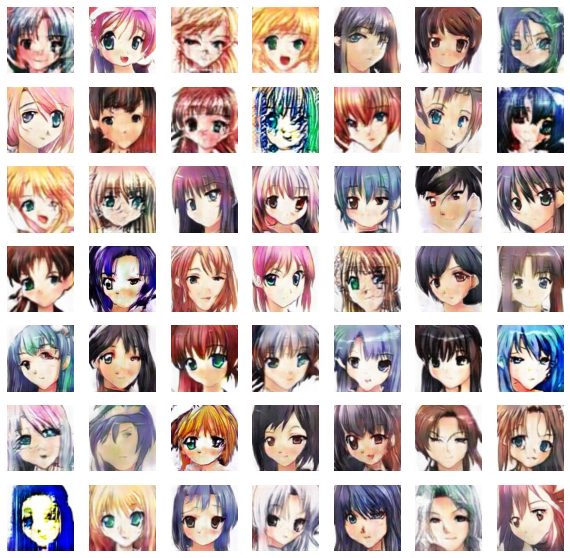

Time for epoch 3 is 646.6871356964111 sec,
 Generator Loss : 0.5642757415771484, 
 Discriminator Loss: 0.1350327581167221


KeyboardInterrupt: ignored

In [ ]:
train(ds, EPOCHS)

In [ ]:
checkpoint.save(file_prefix = checkpoint_prefix)

'/content/drive/My Drive/Sapienza/Vision&Perception/VisionProject/definitiveModel/ckpt-7'

The Tensorboard charts are loaded. 

In [ ]:
#%tensorboard --logdir logs/gradient_tape
%tensorboard --logdir {logs_base_dir}

In [ ]:
display_image(EPOCHS)

the following code generates a gif on the base of the created images

In [ ]:
anim_file = 'LSGAN.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/path/where/images/are/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)
  files.download(anim_file)

In [ ]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)